## Climate Data Analysis
Climate data is from the world bank; read more about these time series [here](https://climateknowledgeportal.worldbank.org/country/uruguay/climate-data-historical).

In [ ]:
!pip install statsmodels --upgrade

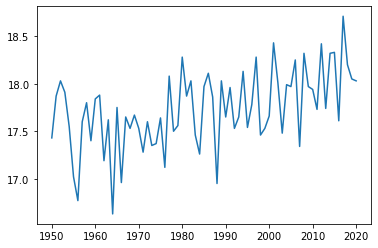

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
climate_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/observed-average-annual-temperature-of-uruguay-for-1901-2020.csv')
climate_df = climate_df[climate_df.year >= 1950] # Need to adjust this to match length of ENSO records
year = climate_df.year.values.reshape(-1,1)
temp = climate_df.annual_mean.values.reshape(-1,1)
plt.plot(year, temp);

### Plot ACF, PACF
Plot the ACF and PACF. Use the package referenced [here (ACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) and [here (PACF)](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html).

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


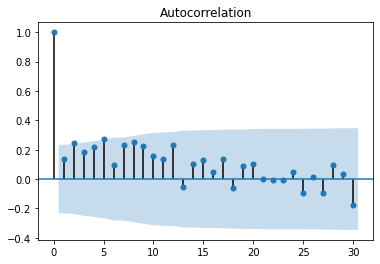

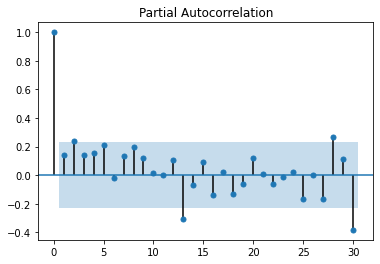

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(temp, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(temp, lags=30)
plt.show()

## Fitting Seasonal Component 
Find the best-fitting seasonal pattern to the data (using the provided sinusoidal approximation) and remove this component from your data. 
Plot the fitted model and the residuals. 

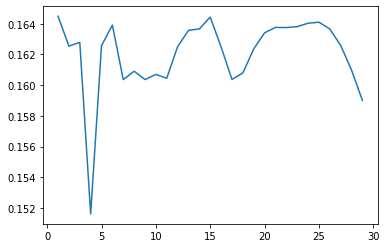

minimizing period is: 4


In [ ]:
from scipy import optimize
period_range = np.arange(1, 30)
mse_list = []

def find_sine_approximation(period, x_data=year, y_data=temp):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, temp)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

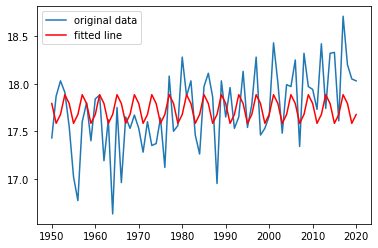

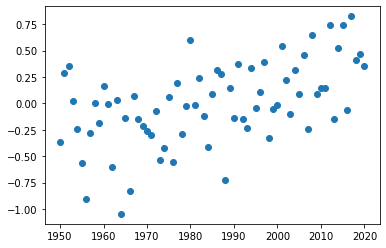

MSE with sinusoidal approximation 0.15160706493447512


In [ ]:
period = period_guess 
temp_sin_hat = find_sine_approximation(period, year, temp)
plt.plot(year, temp, label='original data')
plt.plot(year, temp_sin_hat, 'r', label='fitted line')
plt.legend()
plt.show()
sin_residuals = temp - temp_sin_hat
plt.plot(year, sin_residuals, 'o')
plt.show();
print("MSE with sinusoidal approximation", np.mean((temp - temp_sin_hat)**2))

### Evaluate AIC 
Evaluate the AIC for the sinusoidal model. Assume that in the true model, temperature is a sum of a deterministic component and a Gaussian distributed error term with unknown variance. 

In [ ]:
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, np.mean(residuals), scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, np.mean(residuals), scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)
print("AIC: {}".format(evaluate_AIC(4, sin_residuals)))
print("BIC: {}".format(evaluate_BIC(4, sin_residuals)))

AIC: 75.5503842034037
BIC: 84.60110371156895


## Including ENSO index
ENSO index is from [here](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php); we use ONI, which is a measure of how anomalously warm or cool the central-to-eastern equatorial Pacific Ocean is compared to "normal".

I've aggregated this data to yearly values to standardize the comparison; this index is only available from 1950-2020 so we focus on that range while incorporating this regressor. 

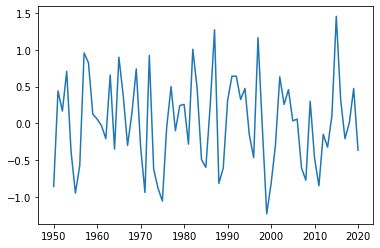

In [ ]:
# No need to change this block; reads data from github
import pandas as pd
enso_df = pd.read_csv('https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/enso_index.csv')
ONI = enso_df['ONI_index'].values.reshape(-1,1)
plt.plot(year, ONI)

[[0.21369093]]


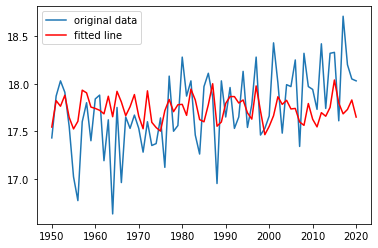

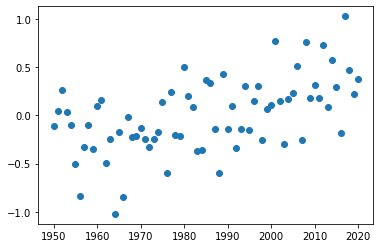

MSE with ENSO: 0.14748969990556732
AIC with ENSO: 67.59548920302558
BIC with ENSO: 69.8581690800669


In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(ONI, temp)
print(clf.coef_)
enso_predictions = clf.predict(ONI)
plt.plot(year, temp, label='original data')
plt.plot(year, enso_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
enso_residuals = temp - enso_predictions
plt.plot(year, enso_residuals, 'o')
plt.show()
print("MSE with ENSO:", np.mean((enso_residuals)**2))
print("AIC with ENSO:", evaluate_AIC(1, enso_residuals))
print("BIC with ENSO:", evaluate_BIC(1, enso_residuals))

### Including both seasonality and ENSO residuals:

4


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


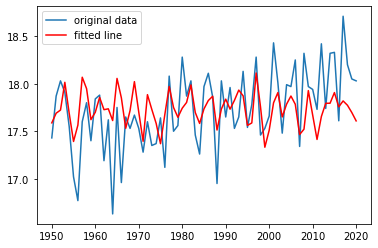

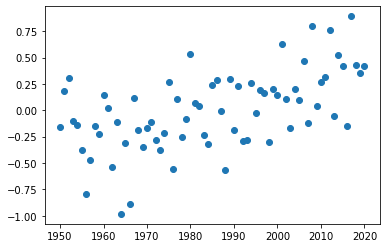

MSE with ENSO and sinusoid: 0.13773201302265717
AIC with ENSO and sinusoid: 70.73564714760812
BIC with ENSO and sinusoid: 82.0490465328147


In [ ]:
for period in period_range:
  sin_prediction = find_sine_approximation(period, year, enso_residuals)
  mse = np.nanmean((temp - sin_prediction) **2)
  mse_list.append(mse)
enso_period_guess = period_range[np.argmin(mse_list)]
print(enso_period_guess)
enso_sin_residuals = enso_residuals - find_sine_approximation(enso_period_guess, year, enso_residuals)
plt.plot(year, temp, label='original data')
plt.plot(year, temp - enso_sin_residuals, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(year, enso_sin_residuals, 'o')
plt.show()
print("MSE with ENSO and sinusoid:", np.mean(enso_sin_residuals**2))
print("AIC with ENSO and sinusoid:", evaluate_AIC(5, enso_sin_residuals))
print("BIC with ENSO and sinusoid:", evaluate_BIC(5, enso_sin_residuals))

## Fit a trend line
As in the simulated exercise, start by fitting a line and plotting the residuals. 

Fit the line to the result from removing the ENSO pattern. 

In [ ]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(year, enso_residuals)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(year)
linear_residuals = enso_residuals - linear_prediction
plt.plot(year, temp, label='original data')
plt.plot(year, temp - linear_residuals, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(year, linear_residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO:", np.mean(linear_residuals**2))
print("AIC with ENSO:", evaluate_AIC(2, linear_residuals))
print("BIC with ENSO:", evaluate_BIC(2, linear_residuals))

NameError: ignored

[[0.01007845 0.23681454 0.99558587]]


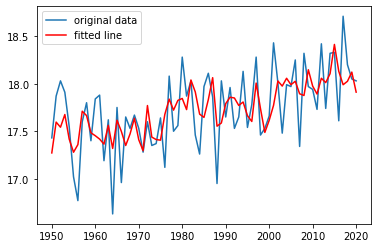

NameError: ignored

In [ ]:
new_x = np.hstack((year, ONI, sin_prediction))
clf.fit(new_x, temp)
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(new_x)
plt.plot(year, temp, label='original data')
plt.plot(year, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = temp - linear_prediction
plt.plot(year, linear_residuals, 'o')
plt.show();
print("MSE with linear fit and accounting for ENSO and sinusoidal pattern:", np.mean((linear_residuals)**2))


MSE from seasonal decomposition 0.0855035235532976


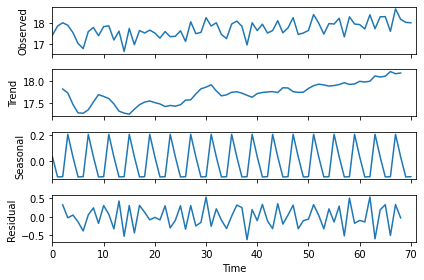

In [ ]:
# Again, we can consider comparing to the statsmodels package. 
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(temp, freq=4)
res.plot()
print("MSE from seasonal decomposition", np.nanmean(res.resid **2))
plt.show()

## Conclusions about Climate Change:
After accounting for internal variability (ENSO or other seasonal components), what is your best guess of the degree of warming since 1950? 

In [ ]:
# To estimate, I use our augmented linear model (this had the best prediction score)
# I multiply the parameter estimate for "year" by the number of years passed. 
estimated_warming = clf.coef_[0][0] * (2020 - 1950)
print(estimated_warming)

0.7054914776969522


# Section 2: AR/MA Models
After completing the above content, wait to move on to this content as a group. 

If you have extra time, you should experiment with other model configurations to see if you improve the information criteria. 
For example, does a nonlinear trend fit better? Does a lagged value of the ENSO index result in a better model? 

## ARIMA Models
For evaluation, we are using [this package](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). 

You could see a guide [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) for examples. 

### First, fit AR(1) model to the data. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -59.734
Date:                Mon, 08 Nov 2021   AIC                            123.468
Time:                        19:13:24   BIC                            127.993
Sample:                             0   HQIC                           125.267
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.004    270.051      0.000       0.992       1.007
sigma2         0.2854      0.061      4.665      0.000       0.165       0.405
Ljung-Box (Q):                       64.90   Jarque-

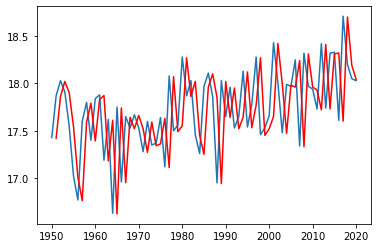

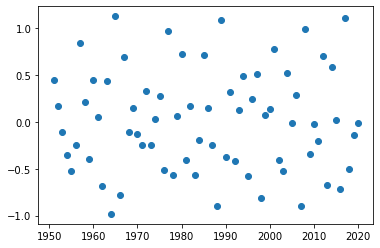

MSE with linear fit and accounting for ENSO: 0.28553031474920443
AIC with ENSO: 114.91293223228222
BIC with ENSO: 119.40992271638093


In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
ar_1 = SARIMAX(temp, order=(1, 0, 0)).fit()
print(ar_1.summary())
ar_1_predictions = ar_1.predict()
ar_1_residuals = temp - ar_1_predictions.reshape(-1,1)
ar_1_residuals = ar_1_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(year, temp, label='original data')
plt.plot(year[1:], ar_1_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(year[1:], ar_1_residuals, 'o')
plt.show()
print("MSE with linear fit and accounting for ENSO:", np.mean(ar_1_residuals**2))
print("AIC with ENSO:", evaluate_AIC(2, ar_1_residuals))
print("BIC with ENSO:", evaluate_BIC(2, ar_1_residuals))

### Fit MA(5) model to the data. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.k_ar > 0 and
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(0, 0, 5)   Log Likelihood                -160.253
Date:                Mon, 08 Nov 2021   AIC                            332.507
Time:                        03:26:25   BIC                            346.083
Sample:                             0   HQIC                           337.905
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          2.1096      0.197     10.721      0.000       1.724       2.495
ma.L2          2.8521      0.399      7.153      0.000       2.071       3.634
ma.L3          2.5523      0.485      5.267      0.0

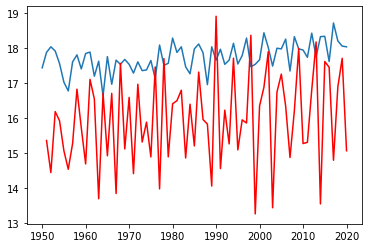

MSE with linear fit and accounting for ENSO: 4.951467567321858
AIC with ENSO: 372.6993257805665
BIC with ENSO: 383.9418019908133


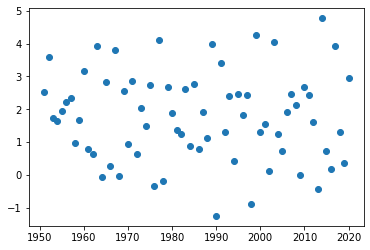

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
ma_5 = SARIMAX(temp, order=(0, 0, 5)).fit()
print(ma_5.summary())
ma_5_predictions = ma_5.predict()
ma_5_residuals = temp - ma_5_predictions.reshape(-1,1)
ma_5_residuals = ma_5_residuals[1:] # Fitting model means removing one observation
plt.plot(year, temp, label='original data')
plt.plot(year[1:], ma_5_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(year[1:], ma_5_residuals, 'o')
plt.show
print("MSE with MA(5):", np.mean(ma_5_residuals**2))
print("AIC with MA(5):", evaluate_AIC(5, ma_5_residuals))
print("BIC with MA(5):", evaluate_BIC(5, ma_5_residuals))

### Include Exogenous Regressors

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(1, 0, 5)   Log Likelihood                 -26.855
Date:                Mon, 08 Nov 2021   AIC                             69.710
Time:                        19:15:38   BIC                             87.812
Sample:                             0   HQIC                            76.909
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2579      0.053      4.841      0.000       0.154       0.362
ar.L1          1.0000      0.001   1423.663      0.000       0.999       1.001
ma.L1         -1.1018      0.726     -1.519      0.1

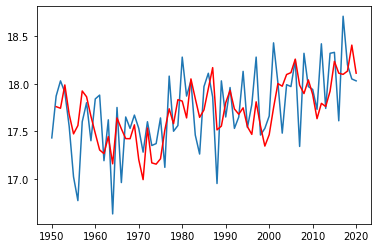

MSE with linear fit and accounting for ENSO: 0.11006751373772738
AIC with ENSO: 62.185812776316794
BIC with ENSO: 82.42226995476102


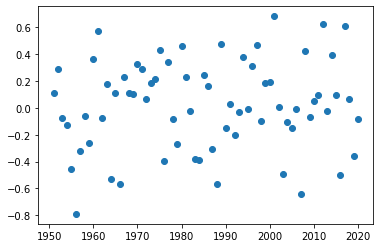

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
exog_arma = SARIMAX(temp, exog=ONI, order=(1, 0, 5)).fit()
print(exog_arma.summary())
exog_arma_predictions = exog_arma.predict()
exog_arma_residuals = temp - exog_arma_predictions.reshape(-1,1)
exog_arma_residuals = exog_arma_residuals[1:] # Fitting model means removing one observation
plt.plot(year, temp, label='original data')
plt.plot(year[1:], exog_arma_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(year[1:], exog_arma_residuals, 'o')
plt.show
print("MSE with exogenous ARMA:", np.mean(exog_arma_residuals**2))
print("AIC with exogenous ARMA:", evaluate_AIC(9, exog_arma_residuals))
print("BIC with exogenous ARMA:", evaluate_BIC(9, exog_arma_residuals))

### Include Exogenous Regressors and Trend
Fit a linear or quadratic trend to the data; how does this improve the model? 
Include AR/MA terms as appropriate and the ENSO term. 

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   71
Model:                        SARIMAX   Log Likelihood                 -20.595
Date:                Mon, 08 Nov 2021   AIC                             49.189
Time:                        19:32:45   BIC                             58.240
Sample:                             0   HQIC                            52.788
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.3735      0.075    231.008      0.000      17.226      17.521
drift          0.0101      0.002      5.333      0.000       0.006       0.014
x1             0.2233      0.085      2.620      0.0

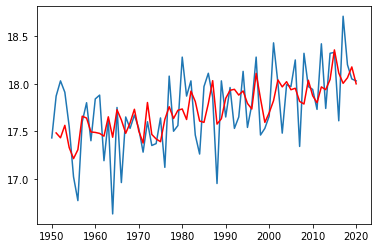

MSE with exogenous ARMA and trend: 0.10527070980711012
AIC with exogenous ARMA and trend: 59.06599100742365
BIC with exogenous ARMA and trend: 79.30244818586789


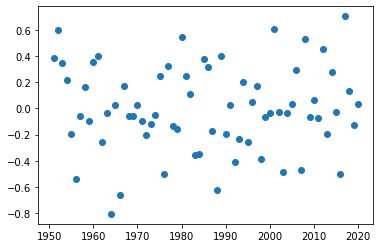

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
exog_arma_trend = SARIMAX(temp, exog=ONI, order=(0, 0, 0), trend=[1,1,0]).fit()
print(exog_arma_trend.summary())
exog_arma_trend_predictions = exog_arma_trend.predict()
exog_arma_trend_residuals = temp - exog_arma_trend_predictions.reshape(-1,1)
exog_arma_trend_residuals = exog_arma_trend_residuals[1:] # Fitting model means removing one observation
plt.plot(year, temp, label='original data')
plt.plot(year[1:], exog_arma_trend_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(year[1:], exog_arma_trend_residuals, 'o')
plt.show
print("MSE with exogenous ARMA and trend:", np.mean(exog_arma_trend_residuals**2))
print("AIC with exogenous ARMA and trend:", evaluate_AIC(9, exog_arma_trend_residuals))
print("BIC with exogenous ARMA and trend:", evaluate_BIC(9, exog_arma_trend_residuals))